In [1]:
"""Temporary fix for importing modules from parent directory"""

import os
import sys

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import sys
import numpy as np
import casadi as cs
import mediapy as media
from tqdm import tqdm
from time import sleep

In [3]:
import pinocchio as pin
import meshcat

In [4]:
from robot_descriptions.bolt_description import URDF_PATH

In [5]:
from darli.model import Model
from darli.model.functional import Functional
from darli.backend import CasadiBackend, Frame, JointType
from darli.backend.liecasadi.so3 import SO3
from darli.state_space import StateSpace
from darli.robots import biped
import casadi as cs

In [6]:
pinmodel, gpinmodel, cpinmodel = pin.buildModelsFromUrdf(URDF_PATH, package_dirs='/home/m8/.cache/robot_descriptions', geometry_types=[pin.GeometryType.VISUAL, pin.GeometryType.COLLISION], root_joint=pin.JointModelFreeFlyer())

In [7]:
pinmodel.nq, pinmodel.nv

(13, 12)

In [8]:
vis = pin.visualize.MeshcatVisualizer(pinmodel, gpinmodel, cpinmodel)

In [9]:
vis.initViewer(loadModel=True)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [10]:
vis.display(pin.neutral(pinmodel))

In [11]:
print(URDF_PATH)

/home/m8/.cache/robot_descriptions/example-robot-data/robots/bolt_description/robots/bolt.urdf


In [12]:
bodies_map={'torso': 'base_link', 'lf': 'FL_FOOT', 'rf': 'FR_FOOT'}
foot_names = {'lf', 'rf'}

stance_leg = 'lf'
swing_leg = 'rf'
 
darli_model = Functional(CasadiBackend(URDF_PATH, root_joint=JointType.FREE_FLYER))

darli_model.add_body(bodies_map)
for foot in foot_names:
    body = darli_model.body(foot)
    if foot == stance_leg:
        body.add_contact(frame=Frame.LOCAL_WORLD_ALIGNED, contact_type="point")
        body.contact.add_cone(mu=1.0)

darli_model.update_selector(passive_joints=range(6))

In [13]:

ns = 60

opti_problem = cs.Opti()
tf = opti_problem.parameter(1)
tf = 0.3
dt = tf / ns

state = opti_problem.variable(darli_model.nq + darli_model.nv, ns+1)
q = state[:darli_model.nq, :]
v = state[darli_model.nq:, :]
u = opti_problem.variable(darli_model.nu, ns)
stance_grw = opti_problem.variable(darli_model.body(stance_leg).contact.dim, ns)

In [14]:
torso_pos = q[:3]
torso_xyzw = q[3:7]

In [15]:
Q_INIT = np.zeros(darli_model.nq)
Q_INIT[2] = 0.45
Q_INIT[6] = 1
vis.display(Q_INIT)

In [16]:
STEP_LENGTH = 0.28
STEP_CLEAREANCE = 0.04

In [17]:

for foot in foot_names:
    INIT_FOOTS = np.array(darli_model.body(foot).position(Q_INIT)).copy()
    foot_pos = darli_model.body(foot).position
    foot_velocity = darli_model.body(foot).linear_velocity.world_aligned
    for i in range(ns+1):
        if foot == stance_leg:
            opti_problem.subject_to(foot_pos(q[:,i]) == INIT_FOOTS)
            cone = darli_model.body(stance_leg).contact.cone.linear()
            if i < ns:
                opti_problem.subject_to(cone@stance_grw[:,i] <= np.zeros(5))
            
    if foot == swing_leg:
        # INTIAL FOOT POSITION
        opti_problem.subject_to(foot_pos(q[:,0])[0] == INIT_FOOTS[0] - STEP_LENGTH/2)
        opti_problem.subject_to(foot_pos(q[:,0])[1:] == INIT_FOOTS[1:])
        opti_problem.subject_to(foot_velocity(q[:,0], v[:,0]) == np.zeros(3))
        # FINAL FOOT POSITION
        opti_problem.subject_to(foot_pos(q[:,-1])[0] == INIT_FOOTS[0] + STEP_LENGTH/2)
        opti_problem.subject_to(foot_pos(q[:,-1])[1:] == INIT_FOOTS[1:])
        opti_problem.subject_to(foot_velocity(q[:,-1], v[:,-1]) == np.zeros(3))
        
        opti_problem.subject_to(foot_pos(q[:,int(ns/2)])[2] >= INIT_FOOTS[2] + STEP_CLEAREANCE)

<!-- TORSO CONSTRAINTS -->

In [18]:
# Y is symmetric 
opti_problem.subject_to(q[1,0] == -q[1,-1])
opti_problem.subject_to(v[1,0] == -v[1,-1])
for i in range(ns):
    # Z of torso is always bounded
    opti_problem.subject_to(q[2,i] >= 0.3)
    opti_problem.subject_to(q[2,i] <= 0.45)
    # Torso have fixed orientation
    opti_problem.subject_to(q[3:7,i] == np.array([0,0,0,1]))

In [19]:

# position_weight = opti_problem.parameter(1)
position_weight = 0.00001
# orientation_weight = opti_problem.parameter(1)
# # acceleration_weight = opti_problem.parameter(1)
# velocity_weight = opti_problem.parameter(1)
velocity_weight = 0.01
control_weight = 0.0001
force_weight = 0.00001

# control_max = opti_problem.parameter(darli_model.nu)

fd = darli_model.forward_dynamics
cost = 0 
for i in range(ns):
    
    dv_i = fd(q[:,i], v[:,i], u[:, i], stance_grw[:,i])
    opti_problem.subject_to(v[:, i+1] == v[:,i] + dt*dv_i)
    opti_problem.subject_to(q[:,i+1] == darli_model.backend.integrate_configuration(q[:,i], v[:,i]*dt))
    # opti_problem.subject_to(q[3:7,i] == np.array([0,0,0,1]))
    cost += position_weight*cs.sumsqr(q[7:,i])*dt
    cost += velocity_weight*cs.sumsqr(v[:,i])*dt
    cost += control_weight*cs.sumsqr(u[:,i])*dt
    cost += force_weight*cs.sumsqr(stance_grw[:,i])*dt
    # cost += acceleration_weight*cs.sumsqr(dv_i)*dt
    # opti_problem.subject_to(opti_problem.bounded(np.zeros(darli_model.nu), u[:, i], control_max))
    # opti_problem.subject_to(q[2, i] >= 0.4)

In [20]:

opti_problem.minimize(cost)
opti_problem.solver('ipopt')

In [21]:
opti_problem.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    30604
Number of nonzeros in inequality constraint Jacobian.:     1028
Number of nonzeros in Lagrangian Hessian.............:    19135

Total number of variables............................:     2065
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1937
Total number of inequality c

OptiSol(Opti {
  instance #0
  #variables: 3 (nx = 2065)
  #parameters: 0 (np = 0)
  #constraints: 430 (ng = 2358)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})

In [22]:
q_solution = opti_problem.value(q)
v_solution = opti_problem.value(v)
u_solution = opti_problem.value(u)
grw_solution = opti_problem.value(stance_grw)

In [23]:
from time import sleep
for i in range(ns+1):
    vis.display(q_solution[:,i])
    sleep(0.01)

In [24]:
q_solution[9]

array([-1.1111664 , -1.1117764 , -1.10618494, -1.09899475, -1.09140742,
       -1.08376396, -1.07616062, -1.06862221, -1.06115285, -1.05375075,
       -1.04641257, -1.0391346 , -1.03191314, -1.02474457, -1.01762535,
       -1.01055208, -1.00352143, -0.99653018, -0.98957518, -0.98265338,
       -0.97576179, -0.96889749, -0.96205764, -0.9552395 , -0.94844059,
       -0.9416592 , -0.93489671, -0.92816726, -0.92153802, -0.91529877,
       -0.91064069, -0.90680219, -0.90453548, -0.9026395 , -0.90081815,
       -0.89899978, -0.89716582, -0.89531018, -0.89342966, -0.89152181,
       -0.88958431, -0.88761494, -0.88561152, -0.88357188, -0.88149391,
       -0.8793755 , -0.87721462, -0.87500926, -0.87275744, -0.87045725,
       -0.86810683, -0.86570436, -0.86324813, -0.86073653, -0.85816832,
       -0.8555437 , -0.85286925, -0.85018103, -0.84765238, -0.84608508,
       -0.84285858])

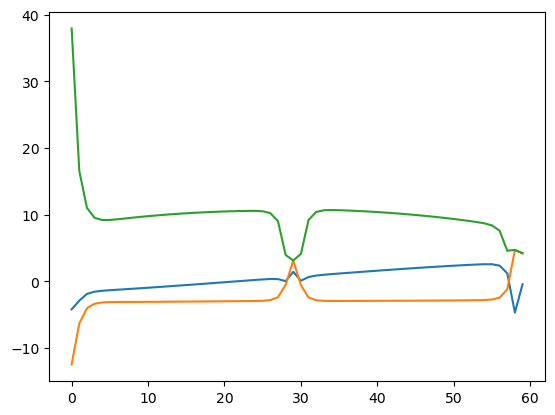

In [25]:

import matplotlib.pyplot as plt

plt.plot(grw_solution.T)
plt.show()

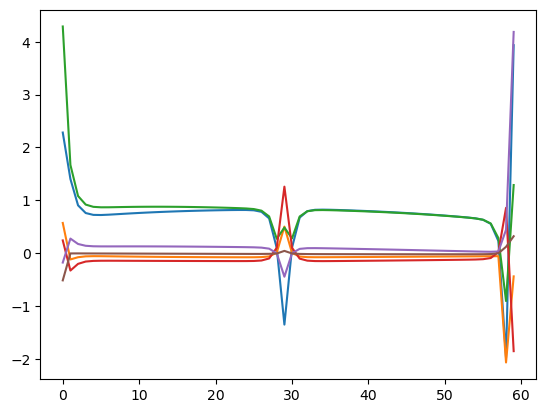

In [26]:
plt.plot(u_solution.T)
plt.show()